In [125]:
#import matplotlib.pyplot as plt
import os
import io
import gc
import math
import random
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, Dense, Flatten, Dropout, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Average
from tensorflow.keras.regularizers import L2
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Model
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.data.experimental import AUTOTUNE
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, CategoricalCrossentropy, AUC
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.cm as cm
from sklearn.utils import shuffle

# Setup a GPU hardware accelerator for quicker training.

In [13]:
#Display information of the currently used GPU (run ONLY if you have nvidia GPU!!!)
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-1787b107-ff98-6116-fc24-6e220d7dfa43)


In [7]:
#GPU acceleration setup
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


# Dataset 1 (Imbalanced Dataset)
This dataset is heavily imbalanced which is not good for model training as a lot of samples are needed for the model to learn and generalise to real world examples

Only a custom model will be implemented for this dataset as other state-of-the-art models don't improve upon the custom model's performance.

## Load the dataset

### Dataset is loaded from tree-like directory structure: 2 folders for train and test. Within each there are 4 folders **(Mild Impairment, Moderate Impairment, No Impairment and Very Mild Impairment)** which represent the classes for the multi-class classification problem.

**NOTE:** ```image_dataset_from_directory``` function initialises a **BatchDataset** which contain batches of samples (each batch contain **32** samples of images and labels)

In [106]:
# IF RUNNING ON LOCAL MACHINE THEN RUN THIS AND COMMENT THE KAGGLE DIRECTORY PATHS!!!
absolute_path = os.path.dirname('ad_classifier.ipynb')
relative_path = "AlzheimersDataset"
data_dir = os.path.join(absolute_path, relative_path)

# IF RUNNING ON KAGGLE THEN UNCOMMENT AND RUN THIS INSTEAD AND COMMENT THE ABOVE LINES
#Dataset location path
#data_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'

#Train and Test directory paths initialised based on OS on which this notebook is ran.
train_dir = os.path.join(data_dir, 'train') #'/kaggle/working/AugmentedTrain'
test_dir = os.path.join(data_dir, 'test')

#Load the train set (80% of the train folder) into a BatchDataset object with samples stored in batches of 32 image samples 
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(122, 122), class_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], label_mode='categorical', labels="inferred", validation_split=0.2, subset="training", seed=42)

#Load the validation set (20% of the train folder)
val_data = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(122, 122), class_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], label_mode='categorical', labels="inferred", validation_split=0.2, subset="validation", seed=42)

#Load test set from test folder (no split however classes are imbalanced which should be kept in mind)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(122, 122), class_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], label_mode='categorical', labels="inferred")


#Display the order of the classes to be used for one-hot encoding
print("Train Classes: {} and Test Classes: {}".format(train_data.class_names, test_data.class_names))

#Normalize the images to be between 0 and 1. We normalize it here to display some images from a batch soon.
train_data = train_data.map(lambda x, y: (x/255, y))
val_data = val_data.map(lambda x, y: (x/255, y))
test_data = test_data.map(lambda x, y: (x/255, y))

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)
                      
#Show the number of batches for train and validation set
print("Training data batch length: {}, Validation data batch length: {} and Test data batch length: {}".format(len(train_data), len(val_data), len(test_data)))

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.
Train Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'] and Test Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Training data batch length: 129, Validation data batch length: 32 and Test data batch length: 40


In [27]:
# Display some labelled image samples from the first batch of the train set
# If images load as expected then we can proceed with training and inference

# Class 1 (index 0): Mild Impairment, Class 2 (index 1): Moderate Impairment,  Class 3 (index 2): No Impairment, Class 4 (index 3): Very Mild Impairment

def display_samples(dataset):
    data_iterator = dataset.as_numpy_iterator()
    batch = data_iterator.next()

    def get_label(index):

        #Show the one-hot encoded labels too for reference
        print("Image at index {}: {}".format(index, str(batch[1][index])))
        if str(batch[1][index]) == "[1. 0. 0. 0.]":
          return "Mild Impairment"
        elif str(batch[1][index]) == "[0. 1. 0. 0.]":
          return "Moderate Impairment"
        elif str(batch[1][index]) == "[0. 0. 1. 0.]":
          return "No Impairment"
        elif str(batch[1][index]) == "[0. 0. 0. 1.]":
          return "Very Mild Impairment"
        else:
          return "N/A"

    fig, ax = plt.subplots(ncols=4, figsize=(20, 18))
    for index, img in enumerate(batch[0][:4]):
        ax[index].imshow(img)
        ax[index].title.set_text(get_label(index))
        #set_label(index)
    plt.show()

Image at index 0: [1. 0. 0. 0.]
Image at index 1: [0. 0. 0. 1.]
Image at index 2: [1. 0. 0. 0.]
Image at index 3: [0. 0. 0. 1.]


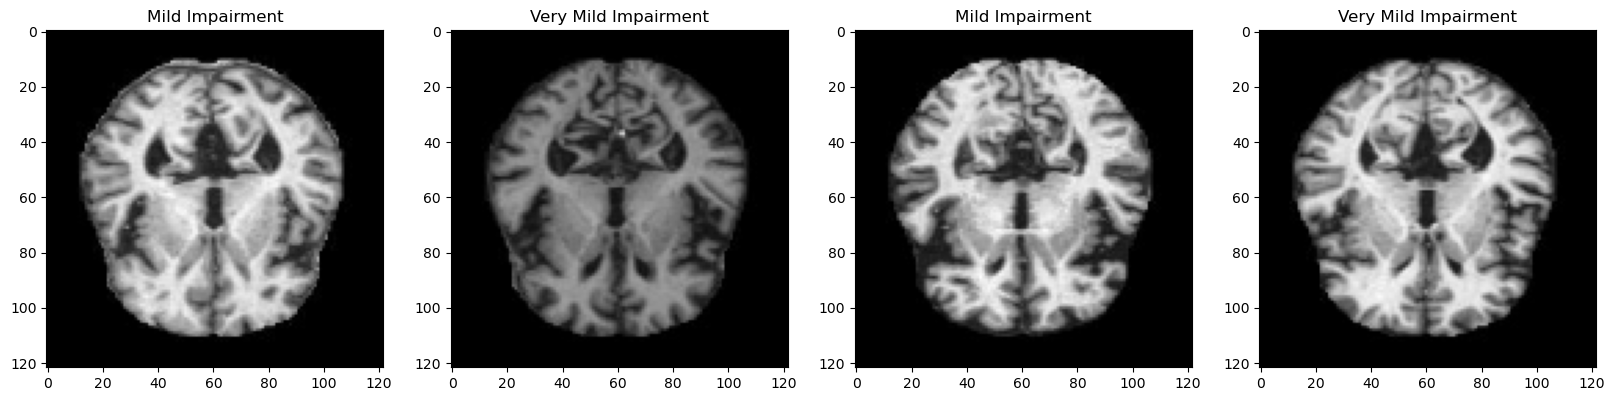

2023-05-10 10:15:54.541647: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [28]:
display_samples(train_data)

### BatchDataset objects sometimes may not be useful as they don't let you choose image samples by index for example. Thus, the code below converts them to numpy arrays if needed for manipulation later. 
**Note**: array objects have been commented out as this process of storing datasets in variables takes up a lot of RAM. This switches off the Kaggle/Google Colab notebooks which have memory limitations.

In [29]:
def convert_ds_to_numpy(dataset):
    images = []
    labels = []

    #To convert the BatchDataset to Numpy Arrays instead
    for batch in dataset.as_numpy_iterator():
        for img in batch[0]:
            images.append(img)

        for label in batch[1]:
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape) 
    
    return images, labels

In [30]:
#Since data subsets are stored in variables they eat up RAM which can cause the notebook/program to crash. 
#To avoid this we can delete such variables that are not in use, you can uncomment the following command if you have a lot of RAM (preferrably 16GB or more)
#Garbage collector (gc) cleans up the RAM

gc.collect()

24157

## Data Resampling

The main issue with the original dataset was the imbalance of classes. **Moderate Demented** class had about 50 training images whilst **NonDemented** and **VeryMildDemented** classes had samples in 1000s. This meant the minority classes had to be resampled to fix the imbalance.

## SMOTE (optional)
### A resampling operation to oversample the minority classes to have the same no. of samples as the majority class by introducing similar synthetic images. However, this approach did not work well with  medical imaging such as brain MR images as high performance couldn't be reached.
**NOTE:** This approach is not used in the final implementation of the code but it is included in the notebook to show that this approach was also tried.

In [37]:
train_images, train_labels = convert_ds_to_numpy(train_data)

(4097, 122, 122, 3) (4097, 4)


In [38]:
# The resample function in SMOTE needs a 2D np array thus the 3 dimensionality of the images needs to be changed to make a vector containing width*height*channel depth values
n_samples, nx, ny, n_channels = train_images.shape
train_images = train_images.reshape((n_samples, nx*ny*n_channels))
train_images.shape

(4097, 44652)

In [7]:
sm = SMOTE(random_state = 42)
train_images, train_labels = sm.fit_resample(train_images, train_labels)

#Reshape the dimensions back to original shapes of the inputs
train_images = train_images.reshape(-1, 122, 122, 3)

In [8]:
#Confirm the shapes are reverted back to normal and we have more images (augmented images have been added)
train_images.shape, train_labels.shape

((8112, 122, 122, 3), (8112, 4))

In [9]:
#Convert the numpy array of image samples to BatchDataset as it's more simpler to feed it for training purposes
smote_train_data = tf.data.Dataset.from_tensor_slices((train_images.astype('float32'), train_labels.astype('float32'))).batch(32)
smote_train_data

<BatchDataset shapes: ((None, 122, 122, 3), (None, 4)), types: (tf.float32, tf.float32)>

In [41]:
#The following variables won't be needed anymore so delete and clean up to save RAM
del train_images, train_labels
gc.collect()

9970

## Class Distribution
The number of samples per each class in a dataset or any subset can be viewed.

### The following function has 2 purposes:
* Find and return the class distribution
* (Optional) Return the samples per each class

## Oversampling
This is method to rebalance the minority classes in an imbalanced dataset (as one used in this project). Random samples from the minority classes are chosen, duplicated, and added back to the train set to increase the sample size.

### **IMPORTANT NOTE:** Be careful whilst running the following cells as both oversampling and class distribution are implemented together. Oversampling was not used in the final implementation as it didn't have significant performance boost

In [42]:
#Code for finding the distribution of the 4 classes (Mild Impairment, Moderate Impairment, No Impairment, Very Mild Impairment)
def class_distribution(dataset, return_class_images=False):
    images = []
    labels = []
    batch_nums = []
    

    for batches in enumerate(dataset.as_numpy_iterator()):
        batch_num, batch = batches
        batch_nums.append(batch_num)

        for image in batch[0]:
            images.append(image)

        for label in batch[1]:
            labels.append(label)


    mild = 0
    moderate = 0
    normal = 0
    vmild = 0
    
    mild_images = []
    moderate_images = []
    normal_images = []
    vmild_images = []
    
    mild_labels = []
    moderate_labels = []
    normal_labels = []
    vmild_labels = []
    
    for i in range(len(labels)):
        if str(labels[i]) == '[1. 0. 0. 0.]':
            mild += 1
            mild_images.append(images[i])
            mild_labels.append(labels[i])
            
        elif str(labels[i]) == '[0. 1. 0. 0.]':
            moderate += 1
            moderate_images.append(images[i])
            moderate_labels.append(labels[i])
            
        elif str(labels[i]) == '[0. 0. 1. 0.]':
            normal += 1
            normal_images.append(images[i])
            normal_labels.append(labels[i])
            
        elif str(labels[i]) == '[0. 0. 0. 1.]':
            vmild += 1
            vmild_images.append(images[i])
            vmild_labels.append(labels[i])
            
    mild_images = np.array(mild_images)
    moderate_images = np.array(moderate_images)
    normal_images = np.array(normal_images)
    vmild_images = np.array(vmild_images)
    
    mild_labels = np.array(mild_labels)
    moderate_labels = np.array(moderate_labels)
    normal_labels = np.array(normal_labels)
    vmild_labels = np.array(vmild_labels)
    
    if return_class_images == False:
        
        del mild_images, moderate_images, normal_images, vmild_images, mild_labels, moderate_labels, normal_labels, vmild_labels, images, labels, batch_nums
        gc.collect()
        
        return [mild, moderate, normal, vmild]
    else:
        
        del images, labels, batch_nums
        gc.collect()
        
        return [mild, moderate, normal, vmild], (mild_images, mild_labels), (moderate_images, moderate_labels), (normal_images, normal_labels), (vmild_images, vmild_labels)

In [43]:
#If you WANT to oversample and get class distribution then uncomment and run the following line: (IMP: Also comment out the next line because we are replacing the function call)
#train_dist, mild_samples, moderate_samples, normal_samples, vmild_samples = class_distribution(train_data, return_class_images=True)

#If you DON"T WANT to oversample the minority classes then run the following line to just get class distribution (DEFAULT setup)
train_dist = class_distribution(train_data, return_class_images=False)

print("Mild: {}, Moderate: {}, Normal: {}, Very Mild: {}".format(train_dist[0], train_dist[1], train_dist[2], train_dist[3]))

Mild: 595, Moderate: 42, Normal: 2028, Very Mild: 1432


In [6]:
#ONLY RUN THIS COMMAND IF YOU DECIDE TO OVERSAMPLE in the cell above, its not used in final implementation
#See the number of samples for each class
#len(mild_samples[0]), len(moderate_samples[0]), len(normal_samples[0]), len(vmild_samples[0])

(595, 42, 2028, 1432)

### **DISCLAIMER:** 

### The following code is adapted from TensorFlow docs:
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [7]:
#ONLY RUN THIS CELL IF YOU ARE OVERSAMPLING FROM THE CELLS ABOVE, its not used in the final implementation

"""
#Get the indexes of all the samples in a class
ids = np.arange(len(mild_samples[0]))

#Choose random indexes n times, where n is the number of samples in the majority class (for rebalancing)
choices = np.random.choice(ids, len(normal_samples[0]))

#Create a resampled set of samples for MildDemented class that has the same number of samples as the majority class (NonDemented)
res_mild_images = mild_samples[0][choices]
res_mild_labels = mild_samples[1][choices]

#Do the same for the other minority classes: ModerateDemented and VeryMildDemented
ids = np.arange(len(moderate_samples[0]))
choices = np.random.choice(ids, len(normal_samples[0]))

res_moderate_images = moderate_samples[0][choices]
res_moderate_labels = moderate_samples[1][choices]

ids = np.arange(len(vmild_samples[0]))
choices = np.random.choice(ids, len(normal_samples[0]))

res_vmild_images = vmild_samples[0][choices]
res_vmild_labels = vmild_samples[1][choices]

print("Majority class is Normal Impairment with {} samples Mild Labels. The images from other classes are upsampled to match the sample length. \nMild Class samples: {} \nModerate Class samples: {} \nVery Mild Class samples: {}"
      .format(len(normal_samples[0]), (res_mild_images.shape, res_mild_labels.shape), (res_moderate_images.shape, res_moderate_labels.shape), (res_vmild_images.shape, res_vmild_labels.shape)))
"""

Majority class is Normal Impairment with 2028 samples Mild Labels. The images from other classes are upsampled to match the sample length. 
Mild Class samples: ((2028, 122, 122, 3), (2028, 4)) 
Moderate Class samples: ((2028, 122, 122, 3), (2028, 4)) 
Very Mild Class samples: ((2028, 122, 122, 3), (2028, 4))


In [8]:
#To get a train set, we need to concaternate samples (the resampled set) from all the classes
resampled_images = np.concatenate([res_mild_images, res_moderate_images, normal_samples[0], res_vmild_images], axis=0)
resampled_labels = np.concatenate([res_mild_labels, res_moderate_labels, normal_samples[1], res_vmild_labels], axis=0)

#Shuffle the dataset else the first 25% of the train set would be one class, then next 25% would be another class and so on
#This is done so most or all classes are present in each batch which is what's used during training
resampled_images, resampled_labels = shuffle(resampled_images, resampled_labels, random_state=0)

#Delete and clean up the variables not in use as they eat up RAM
del res_mild_images, res_moderate_images, normal_samples[0], res_vmild_images
del res_mild_labels, res_moderate_labels, normal_samples[1], res_vmild_labels
gc.collect()

resampled_images.shape, resampled_labels.shape

((8112, 122, 122, 3), (8112, 4))

### Visualization for class distribution
Class distribution can easily be understood using bar charts (easier to look for imbalance). This can also be done for all subsets of the dataset (e.g. train, validation, test sets).

In [44]:
#Function to display a bar chart with class distribution of the 4 classes
def bar_chart(labels, values):
    plt.figure(figsize=(12, 8))
    plt.barh(labels, values)
    for index, value in enumerate(values):
        plt.text(value, index, str(value))
        
    plt.show()

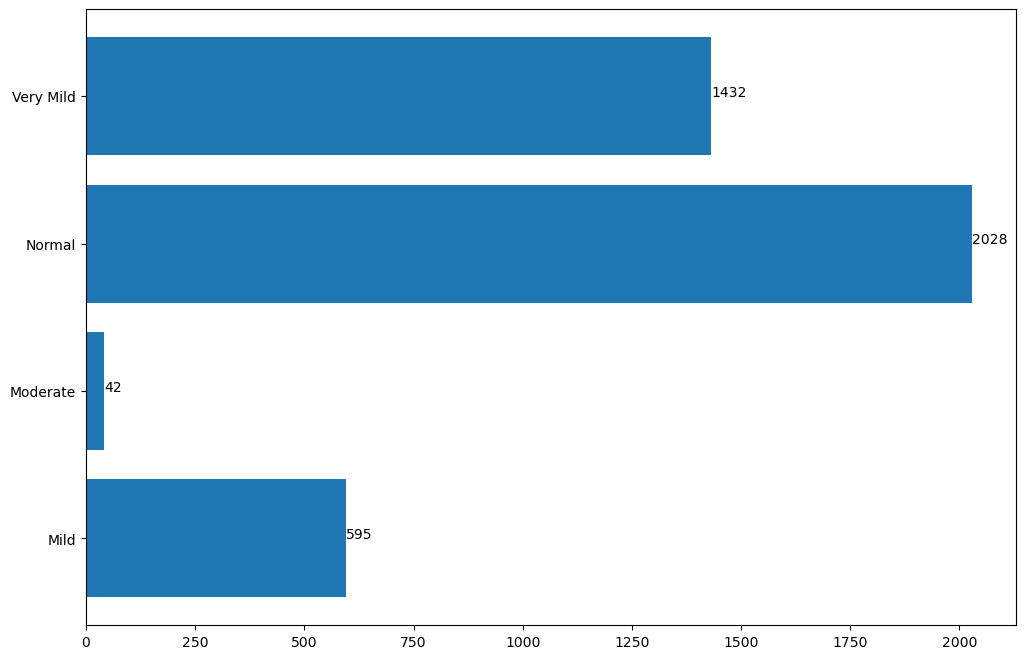

None


In [45]:
#Class distribution for the train set
#Classes are displayed in this order because index position matters!!! (as defined at the start)
print(bar_chart(['Mild', 'Moderate', 'Normal', 'Very Mild'], train_dist))

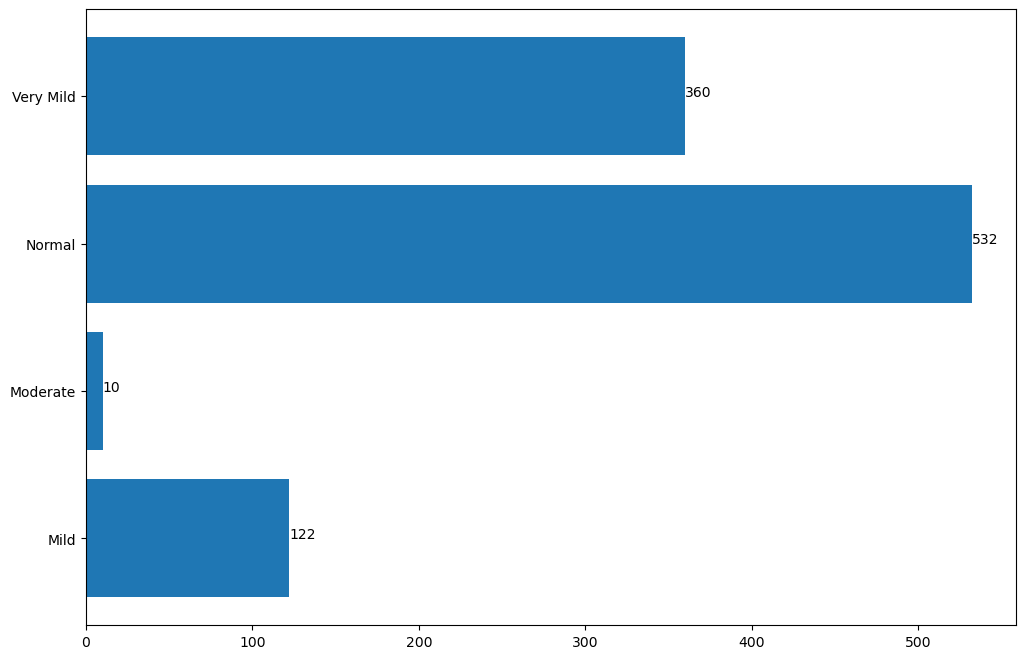

None


In [46]:
#Class distribution for validation set
validation_distribution = class_distribution(val_data)
print(bar_chart(['Mild', 'Moderate', 'Normal', 'Very Mild'], validation_distribution))

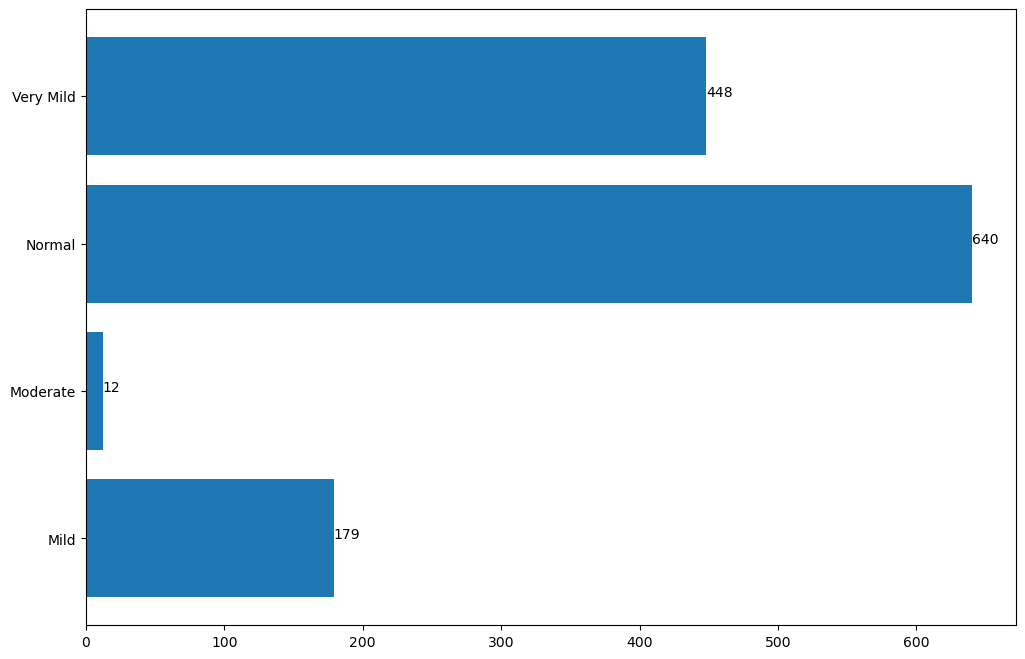

None


In [47]:
#Class distribtuion for the test set
test_distribution = class_distribution(test_data)
print(bar_chart(['Mild', 'Moderate', 'Normal', 'Very Mild'], test_distribution))

## **Data augmentation** 
Simple data augmentation can be performed with Keras' inbuilt ImageDataGenerator but this did not help improve the performance much as the medical brain MR images are small and complex to augment and import features are lost with such simple augmentation causing the model to not perform well enough on the test set

### **IMPORTANT NOTE:** Run the following 3 cells CAREFULLY as dataset is being changed. Once c  This approach not used in the final implementation due to insignificant performance boost

First run an OS command to delete AugmentedTrain if it exists
If you get a syntax error, it means there's no AugmentedTrain directory and you can continue to the next cell

In [79]:
ls

AlzheimersDataset/      ad_classifier.ipynb     research_model/
AugmentedTrain/         custom_finetuned_model/ static/
Combined Dataset/       ensemble_model/         vgg_model/
__pycache__/            predict_app.py


In [65]:
rm -r AugmentedTrain

Make the AugmentedTrain folder and the classes directories to store the augmentations

In [66]:
mkdir 'AugmentedTrain' && cd 'AugmentedTrain' && mkdir MildDemented ModerateDemented VeryMildDemented NonDemented

Since NonDemented class is the majority class we don't need to augment any samples, we can just use the same samples from the original dataset

#### IMPORTANT NOTE: Navigate to the FinalYrProject directory to run the copy (cp) command (maybe different on your machine)

In [77]:
cd ..

/Users/main/Desktop/lab2/FinalYrProject


In [78]:
cp -r 'AlzheimersDataset/train/NonDemented' 'AugmentedTrain'

#### IMPORTANT NOTE: Navigate to the FinalYrProject directory or kaggle/working (if on Kaggle notebook) to run the augmentation cell block below

In [90]:
cd ..

/Users/main/Desktop/lab2/FinalYrProject


In [92]:
data_dir = train_dir
save_dir = "./AugmentedTrain"

upsample_classes = ['MildDemented', 'ModerateDemented', 'VeryMildDemented']
target_size = len([os.path.join(data_dir,'NonDemented', filename) for filename in os.listdir(data_dir+'/NonDemented')])

train_datagen = ImageDataGenerator(
    rotation_range=5,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    brightness_range=[0.5,1.0],
)

for current_class in upsample_classes:
    #print("Generating augmentations for {}".format(current_class))
    
    class_path = os.path.join(data_dir, current_class)
    save_path = os.path.join(save_dir, current_class)
    #count = len(fnmatch.filter(class_path, '*.*'))

    # Loop through all the images in the original directory and perform data augmentation
    files = [os.path.join(class_path, filename) for filename in os.listdir(class_path)]
    
    file_names = files.copy()
    
    class_imbalance_ratio = target_size/len(files)
    
    class_count = len(files)
    
    if class_imbalance_ratio >= 2:
        #Generate 2 or more augmentations
        print("Generating augmented samples for {} class. \nBatch size per image: {}".format(current_class, math.ceil(class_imbalance_ratio)))
        for i in range(class_count):
            image_path = random.choice(file_names)
            file_names.remove(image_path)
            
            # Load the image from file
            img = tf.keras.utils.load_img(image_path)
            # Convert the image to an array
            x = tf.keras.utils.img_to_array(img)
            
            image_save_path = image_path.replace(class_path+"/",save_path+'/')
            #print(image_save_path)
            tf.keras.utils.save_img(image_save_path, x)
            
            # Reshape the array to have a batch size of 1
            x = x.reshape((1,) + x.shape)
            
            
            # Generate augmented images and save them to the save_path
            batch_size = math.ceil(class_imbalance_ratio)
            prefix = "Aug" + current_class
            
            aug_idx = 0
            for batch in train_datagen.flow(x, batch_size=1, save_to_dir=save_path, save_prefix=prefix, save_format='jpg'):
                aug_idx += 1
                if aug_idx >= batch_size:
                    break
            
    elif 1 <= class_imbalance_ratio < 2:
        #Generate 1 augmentation of few existing samples only
        images_needed_count = target_size-class_count
        print("Generating augmented samples for {} class. \n{} images are needed and will be generated by randomly choosing select samples to augment. \nBatch size per image: 1".format(current_class, images_needed_count))
        
        for i in range(images_needed_count):
            image_path = random.choice(file_names)
            file_names.remove(image_path)
            
            # Load the image from file
            img = tf.keras.utils.load_img(image_path)
            # Convert the image to an array
            x = tf.keras.utils.img_to_array(img)
            # Reshape the array to have a batch size of 1
            x = x.reshape((1,) + x.shape)
            
            
            # Generate augmented images and save them to the save_path
            prefix = "Aug" + current_class
            for batch in train_datagen.flow(x, batch_size=1, save_to_dir=save_path, save_prefix=prefix, save_format='jpg'):
                break
            
                
        for img_path in files:

            img = tf.keras.utils.load_img(img_path)
            img = tf.keras.utils.img_to_array(img)
            image_save_path = img_path.replace(class_path+"/",save_path+'/')
            tf.keras.utils.save_img(image_save_path, img)
            
    elif 0 < class_imbalance_ratio < 1:
        #Need to reduce samples
        print("Reducing random samples from {} class to {} images".format(current_class, target_size))
        for i in range(target_size):
            image_path = random.choice(file_names)
            file_names.remove(image_path)
            
            # Load and save the image from original directory to save directory
            img = tf.keras.utils.load_img(image_path)
            img = tf.keras.utils.img_to_array(img)
            image_save_path = image_path.replace(class_path+"/",save_path+'/')
            tf.keras.utils.save_img(image_save_path, img)
            
    else:
        print("ERROR: Data augmentation cannot be completed as the class imbalance ratio (target size/class size) is not above 0!")

Generating augmented samples for MildDemented class. 
Batch size per image: 4
Generating augmented samples for ModerateDemented class. 
Batch size per image: 50
Generating augmented samples for VeryMildDemented class. 
768 images are needed and will be generated by randomly choosing select samples to augment. 
Batch size per image: 1


### IMPORTANT: The following three blocks were not used in final implementation due to insignificant performance boost and very long training times (especially if your machine does not have NVIDIA GPUs)

#### It is instead advised to skip these 3 cells (thus the commands have been commented out by default) and move on to CNN model architecture section 

In [93]:
#del train_data
gc.collect()

4708

In [94]:
aug_train_dir = 'AugmentedTrain'
#train_data = tf.keras.utils.image_dataset_from_directory(aug_train_dir, image_size=(122, 122), class_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], label_mode='categorical', labels="inferred")
#train_data = train_data.map(lambda x, y: (x/255, y))
#train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)

Found 10650 files belonging to 4 classes.


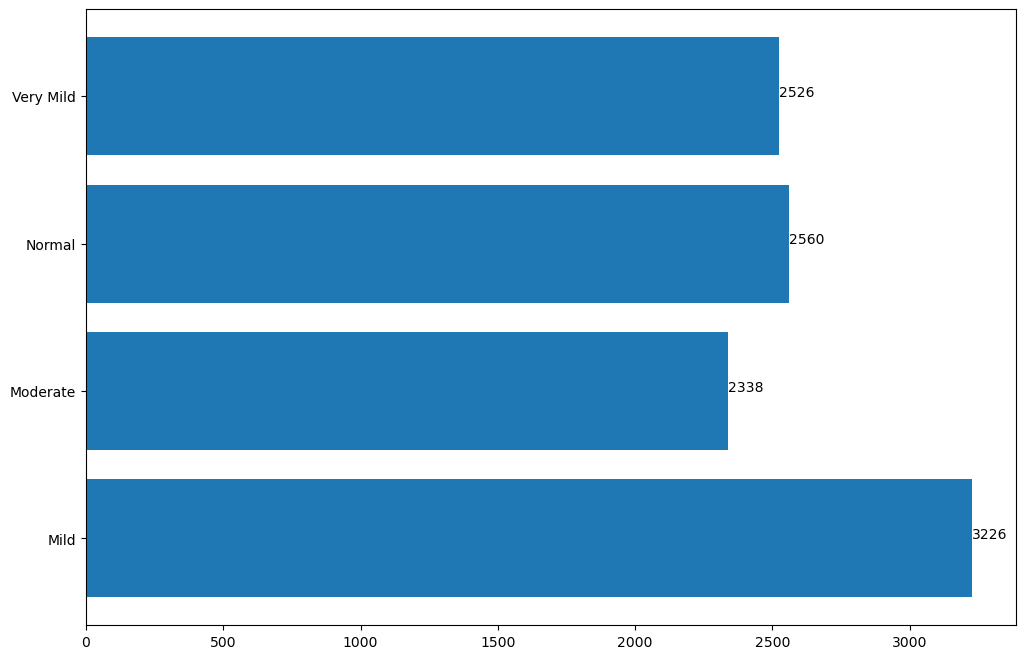

None


In [95]:
train_distribution = class_distribution(train_data)
print(bar_chart(['Mild', 'Moderate', 'Normal', 'Very Mild'], train_distribution))

# **CNN Model architecture**

### The custom CNN is inspired from a state-of-art-architecture called LeNet-5 (http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) and a research paper (https://ieeexplore-ieee-org.ezproxy3.lib.le.ac.uk/document/9183023) where the authors developed a well performing model to be used on brain MR images for classification problems.

* Shallow networks were found to have better performance in preliminary model building so, LeNet-5 (by LeCun et. al) based CONV-POOL architecture found in the article "GradientBased Learning Applied to Document Recognition" was considered.
* Another research paper by Baranwal et. al (Performance analysis of Brain Tumour Image Classification using CNN and SVM) made use of a similar architecture for brain tumour classification: They had 5 CONV-POOL blocks followed by a Dropout and FC layers for classification. My approach builds upon their work by changing some of the layers and fine-tuning hyperparameters for this dataset.

### The model's layers are then fine-tuned for the Alzheimer's dataset to improve performance

In [68]:
#Custom CNN model built using ideas from a research paper

#Hyperparameter finetuning using keras tuner
def finetune_model(hp):
    
    #Initialise a sequential model which runs through a layers in a sequential manner.
    model = tf.keras.models.Sequential()
    
    #The architecture below has conv blocks indicated by the empty new lines found below. 
    #There are 5 conv blocks, each containing a Convolution layer (to learn features) and MaxPooling layer (for downsampling)
    
    #Allow the tuner to choose values between 32 and 512 in steps of 32 i.e. 64, 96, 128...
    hp_units1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    hp_ks1 = hp.Choice('kernel_size_1', values=[1, 3, 5], default=3)
    model.add(Conv2D(hp_units1, hp_ks1, activation='relu', padding='same', input_shape = (122,122,3)))
    model.add(MaxPooling2D())
    
    hp_units2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    hp_ks2 = hp.Choice('kernel_size_2', values=[1, 3, 5], default=3)
    model.add(Conv2D(hp_units2, hp_ks2, activation='relu', padding='same'))
    model.add(MaxPooling2D())
    
    hp_units3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
    hp_ks3 = hp.Choice('kernel_size_3', values=[1, 3, 5], default=3)
    model.add(Conv2D(hp_units3, hp_ks3, activation='relu', padding='same'))
    model.add(MaxPooling2D())
    
    hp_units4 = hp.Int('units_4', min_value=32, max_value=512, step=32)
    hp_ks4 = hp.Choice('kernel_size_4', values=[1, 3, 5], default=3)
    model.add(Conv2D(hp_units4, hp_ks4, activation='relu', padding='same'))
    model.add(MaxPooling2D())
    
    hp_units5 = hp.Int('units_5', min_value=32, max_value=512, step=32)
    hp_ks5 = hp.Choice('kernel_size_5', values=[1, 3, 5], default=3)
    model.add(Conv2D(hp_units5, hp_ks5, activation='relu', padding='same'))
    model.add(MaxPooling2D())
    
    #Flatten layer reduces the dimensionality of the previous max pooling layer's output by performing width*height*feature depth multiplication to form a 1D vector which can be passed to FC layer 
    model.add(Flatten())
    
    #The Fully Connected/Dense layer multiplies the features with the output of the flatten layer to get more parameters 
    #Just like in Conv2D layers the values are between 32 and 512 with a step of 32
    dense_units = hp.Int('dense_units', min_value=32, max_value=512, step=32)
    model.add(Dense(dense_units, activation='relu'))
    
    dr_units = hp.Choice('dropout_rate', values=[0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9])
    model.add(Dropout(dr_units))
    
    model.add(Dense(4, activation ='softmax')) # 4 features because its a 4 labels classification. Softmax activation used because it outputs values of all 4 nodes as probabilities summing to 1.
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    #Adam is the optimizer of choice as the gradient descent algorithm.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss='categorical_crossentropy', #Categorical Cross Entropy is used because we are trying to predict classes in a classification problem and all labels are one-hot encoded
                metrics=['accuracy']) #The performance metric we are mainly interested in is the accuracy and loss (not explicitly defined but it's displayed in training)
    return model

#Initialise the keras tuner (kt) by passing it into the model
finetune_model(kt.HyperParameters())

#Hyperband search is used for finetuning which uses a championship bracket like approach to compare hyperparameters. 
#The best hyperparameters move to the next round where epochs are increased and peformance is compared again. This is repeated till the best param values are found by the last epoch specified.
tuner = kt.Hyperband(finetune_model,
                     objective='val_accuracy', #Validation accuracy is prioritised for hyperparametersearch as it's directly correlated to test accuracy which is our performance metric to improve
                     max_epochs=10, #Epochs shouldn't be too low as it's difficult to know performance of a running model and huge epochs would be time-consuming.
                     factor=3,
                     directory='/kaggle/working/hp_tuning/',
                     project_name='cnn_kt')

#If the validation loss isn't decreasing then allow training for another 5 epochs in case it decreasing by then. Used to find the convergence point.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#Hyperparameter search using keras tuner. 30 trials of different hyperparameter combinations are tried to find the one with best validation accuracy.
#Code commented out as the search is time-consuming
tuner.search(train_data, validation_data=val_data , epochs=30, callbacks=[early_stopping])

# Get the best hyperparameter combination found during the search
best_hps=tuner.get_best_hyperparameters(num_trials=3)

Trial 30 Complete [00h 01m 31s]
val_accuracy: 0.650390625

Best val_accuracy So Far: 0.65625
Total elapsed time: 00h 18m 18s


In [31]:
# Get the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=3)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first CONV network is {best_hps.get('units_1')}, {best_hps.get('units_2')}, {best_hps.get('units_3')}, {best_hps.get('units_3')}, {best_hps.get('units_4')}, {best_hps.get('units_5')}, FC layer is {best_hps.get('dense_units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# IMPORTANT NOTE: the no. of features for the 3rd Conv block should be 192 not 320. It was a printing mistake.


The hyperparameter search is complete. The optimal number of units in the first CONV network is 480, 320, 320, 192, 512, 288, FC layer is 352 and the optimal learning rate for the optimizer
is 0.0001.



In [114]:
#Custom CNN with updated hypeparameter values found from the tuner search
def create_model():
    
    #Clear any models defined to save RAM
    tf.keras.backend.clear_session()

    cnn_model = Sequential()

    cnn_model.add(Conv2D(480, (3, 3), activation='relu', padding='same', input_shape = (122, 122, 3)))
    cnn_model.add(MaxPooling2D())
    
    cnn_model.add(Conv2D(320, (3, 3), activation='relu', padding='same'))
    cnn_model.add(MaxPooling2D())

    cnn_model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
    cnn_model.add(MaxPooling2D())

    cnn_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    cnn_model.add(MaxPooling2D())

    cnn_model.add(Conv2D(288, (3, 3), activation='relu', padding='same'))
    cnn_model.add(MaxPooling2D())

    cnn_model.add(Flatten())
    
    cnn_model.add(Dense(352, activation='relu'))
    cnn_model.add(Dropout(0.5))
    
    cnn_model.add(Dense(4, activation ='softmax'))
    
    return cnn_model

cnn_model = create_model()
cnn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #Updated learning rate, lower rate means more epochs are needed for convergence (point of minimal loss) 
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

cnn_model.build((None,122,122, 3))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 122, 480)     13440     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 480)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 320)       1382720   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 320)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 192)       553152    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 192)      0

# Model Training

#### All models defined in the previous section are trained usually with early stopping so that the models don't overfit

### IMPORTANT NOTE: Run the code block on callbacks below before performing ANY training!!!


In [100]:
ls

AlzheimersDataset/      ad_classifier.ipynb     research_model/
AugmentedTrain/         custom_finetuned_model/ static/
Combined Dataset/       ensemble_model/         vgg_model/
__pycache__/            predict_app.py


In [102]:
#Setup callbacks for training
from tensorflow.keras import callbacks

#Store logs of each training session
log_dir = './logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

#Early stopping callback when the model stops improving (once it reaches minimal loss point). 
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", 
                                        patience=5, #Let the model continue for 5 more epochs in case the loss is reduced by then.
                                        restore_best_weights=True)

In [30]:
#Custom Model training
history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    callbacks=[tensorboard_callback], #Make sure to run the callback code block before running this .fit function
    epochs=40 
)

Epoch 1/13
129/129 [==============================] - 12s 89ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.0381 - val_accuracy: 0.9883
Epoch 2/13
129/129 [==============================] - 11s 87ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.0403 - val_accuracy: 0.9902
Epoch 3/13
129/129 [==============================] - 11s 87ms/step - loss: 0.0188 - accuracy: 0.9927 - val_loss: 0.0670 - val_accuracy: 0.9775
Epoch 4/13
129/129 [==============================] - 11s 87ms/step - loss: 0.0229 - accuracy: 0.9929 - val_loss: 0.0536 - val_accuracy: 0.9814
Epoch 5/13
129/129 [==============================] - 11s 87ms/step - loss: 0.0268 - accuracy: 0.9902 - val_loss: 0.0892 - val_accuracy: 0.9678
Epoch 6/13
129/129 [==============================] - 11s 87ms/step - loss: 0.0123 - accuracy: 0.9966 - val_loss: 0.0319 - val_accuracy: 0.9883
Epoch 7/13
129/129 [==============================] - 11s 87ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy:

In [31]:
model_metrics = cnn_model.evaluate(test_data, verbose=2)
model_metrics

40/40 - 1s - loss: 1.4864 - accuracy: 0.7013


[1.4863638877868652, 0.7013291716575623]

# Model Evaluation and Performance Analysis
We are mainly interested in the loss and accuracy metrics for train, validation and test sets. But other metrics are also considered so we know more about the model abilities.

In [12]:
#Display the Loss and Accuracy graphs
#Also show the comparison between training and validation (val_) metrics. To see if model is learning.
def display_loss_and_accuracy_graphs(history):
    fig = plt.figure()
    plt.plot(history.history['loss'], color='teal', label='loss')
    plt.plot(history.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc='upper left')

    fig1 = plt.figure()
    plt.plot(history.history['accuracy'], color='teal', label='acc')
    plt.plot(history.history['val_accuracy'], color='orange', label='val_acc')
    fig1.suptitle('Accuracy', fontsize=20)
    plt.legend(loc='upper left')
    plt.show()

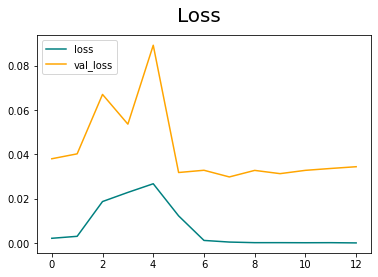

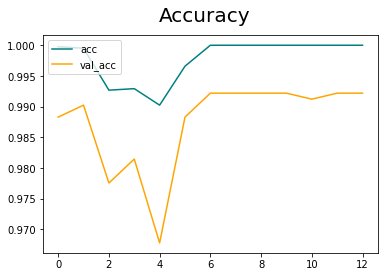

In [33]:
display_loss_and_accuracy_graphs(history)

In [16]:
#Convert regular list to np array
def conv_list_to_array(labels_list):
    labels_arr = labels_list[0].argmax(axis=-1)

    for label in labels_list[1:]:
        labels_arr = np.append(labels_arr, label.argmax(axis=-1))

    return labels_arr

#Get the true (actual) and predicted labels. Also print relevant performance metrics of the model.
def get_labels_and_metrics(model, batch_dataset):
    
    pre = Precision()
    re = Recall()
    acc = CategoricalAccuracy()
    auc = AUC()
    loss = CategoricalCrossentropy()

    actual_labels = []
    predicted_labels = []

    for batch in batch_dataset.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X)

        pre.update_state(y, yhat)
        re.update_state(y, yhat)
        acc.update_state(y, yhat)
        auc.update_state(y, yhat)
        loss.update_state(y, yhat)

        actual_labels.append(y)
        predicted_labels.append(yhat)
        #for i in range(30):
        #    print("Actual class: ", y[i], "Predicted class: ", yhat[i], yhat[i].max())
    
    f1_score = 2 * (pre.result().numpy() * re.result().numpy()) / (pre.result().numpy() + re.result().numpy())

    print("Accuracy: ", acc.result().numpy(),"\nLoss: ",loss.result().numpy(), "\nAUC: ",auc.result().numpy(), "\nPrecision: ",pre.result().numpy(),"\nRecall: ", re.result().numpy(), "\nF1-score: ",f1_score)
    
    actual_labels_arr = conv_list_to_array(actual_labels)
    predicted_labels_arr = conv_list_to_array(predicted_labels)
    
    return actual_labels_arr, predicted_labels_arr


In [35]:
cnn_test_labels, cnn_pred_labels = get_labels_and_metrics(cnn_model, test_data)

Accuracy:  0.7013292 
Loss:  1.4556179 
AUC:  0.88114464 
Precision:  0.70449173 
Recall:  0.6989836 
F1-score:  0.7017269045877401


In [15]:
#Display classification report and confusion matrix
def performance_metrics(y_actual, y_predicted, labels):
    
    print(classification_report(y_actual, y_predicted, target_names = labels))

    con_matrix = confusion_matrix(y_actual, y_predicted)

    cm_display = ConfusionMatrixDisplay(confusion_matrix = con_matrix, display_labels = labels)
    fig, ax = plt.subplots(figsize=(12,8))
    ax.title.set_text("Confusion Matrix for model's performance on test set")
    
    cm_display.plot(ax=ax)

              precision    recall  f1-score   support

        Mild       0.74      0.44      0.55       179
    Moderate       1.00      0.42      0.59        12
      Normal       0.80      0.74      0.77       640
   Very Mild       0.59      0.76      0.66       448

    accuracy                           0.70      1279
   macro avg       0.78      0.59      0.64      1279
weighted avg       0.72      0.70      0.70      1279



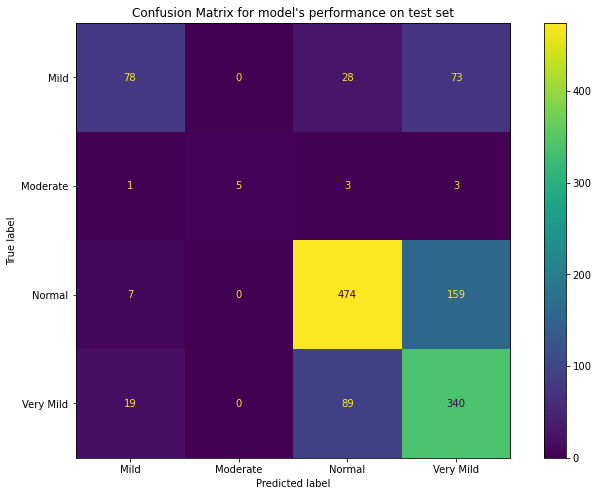

In [37]:
performance_metrics(cnn_test_labels, cnn_pred_labels, labels = ['Mild', 'Moderate', 'Normal', 'Very Mild'])

# Dataset 2 (Balanced Dataset)

This dataset is derived from the original imbalanced dataset by applying some deep learning data augmentation techniques i.e. Generative Adversarial Network (GAN) to generate synthetic brain MR images for minority classes for oversampling. Thus, all classes have 2560 files making the dataset much more balanced. This will certainly improve model performance.

In [107]:
#Dataset location path

#IF RUNNING ON LOCAL MACHINE THEN DO THIS
absolute_path = os.path.dirname('ad_classifier.ipynb')
relative_path = "Combined Dataset"
data_dir = os.path.join(absolute_path, relative_path)

#IF RUNNING ON KAGGLE THEN UNCOMMENT AND DO THIS INSTEAD
#data_dir = '/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset'

#Train and Test directory paths initialised based on OS on which this notebook is ran.
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

#Load the train set (80% of the train folder) into a BatchDataset object with samples stored in batches of 32 image samples 
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(224, 224), class_names=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], label_mode='categorical', labels="inferred", validation_split=0.2, subset="training", seed=42)

#Load the validation set (20% of the train folder)
val_data = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(224, 224), class_names=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], label_mode='categorical', labels="inferred", validation_split=0.2, subset="validation", seed=42)

#Load test set from test folder (no split however classes are imbalanced which should be kept in mind)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(224, 224), class_names=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], label_mode='categorical', labels="inferred")


#Display the order of the classes to be used for one-hot encoding
print("Train Classes: {} and Test Classes: {}".format(train_data.class_names, test_data.class_names))

#Normalize the images to be between 0 and 1. We normalize it here to display some images from a batch soon.
train_data = train_data.map(lambda x, y: (x/255, y))
val_data = val_data.map(lambda x, y: (x/255, y))
test_data = test_data.map(lambda x, y: (x/255, y))

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)
                      
#Show the number of batches for train and validation set
print("Training data batch length: {}, Validation data batch length: {} and Test data batch length: {}".format(len(train_data), len(val_data), len(test_data)))

Found 10240 files belonging to 4 classes.
Using 8192 files for training.
Found 10240 files belonging to 4 classes.
Using 2048 files for validation.
Found 1279 files belonging to 4 classes.
Train Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'] and Test Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
Training data batch length: 256, Validation data batch length: 64 and Test data batch length: 40


In [108]:
#Clean up RAM since we just loaded datasets into variables
gc.collect()

1899

### Display 4 samples from the first batch of the train subset

Image at index 0: [0. 1. 0. 0.]
Image at index 1: [0. 0. 0. 1.]
Image at index 2: [1. 0. 0. 0.]
Image at index 3: [0. 1. 0. 0.]


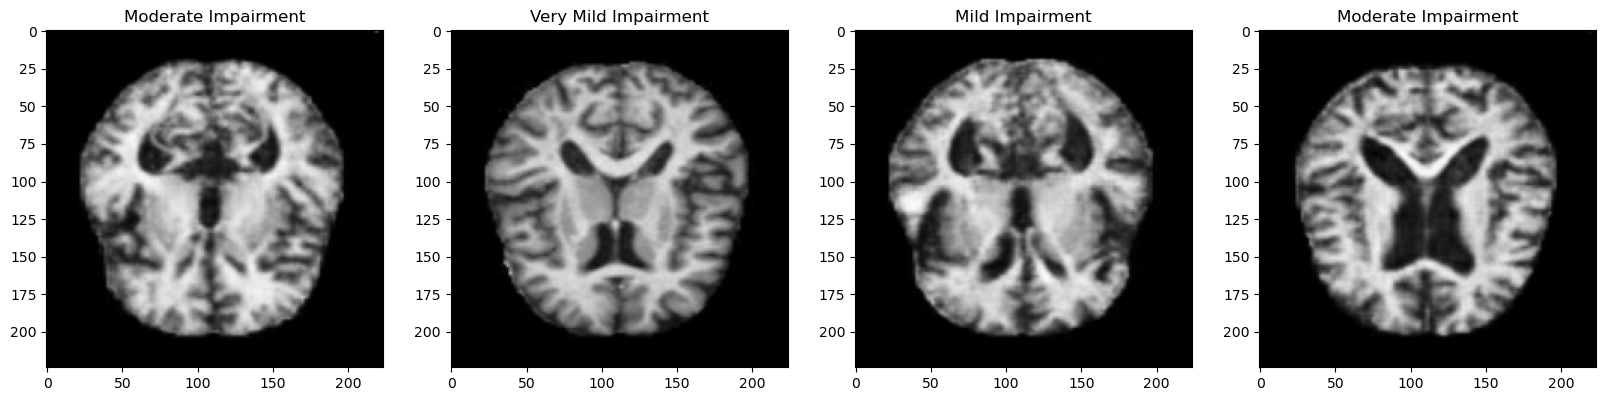

2023-05-10 11:13:51.209368: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [110]:
display_samples(train_data)

### Display class distribution
The GAN generated samples and real samples are concatenated within each class for oversampling, thus, making the dataset much more balanced

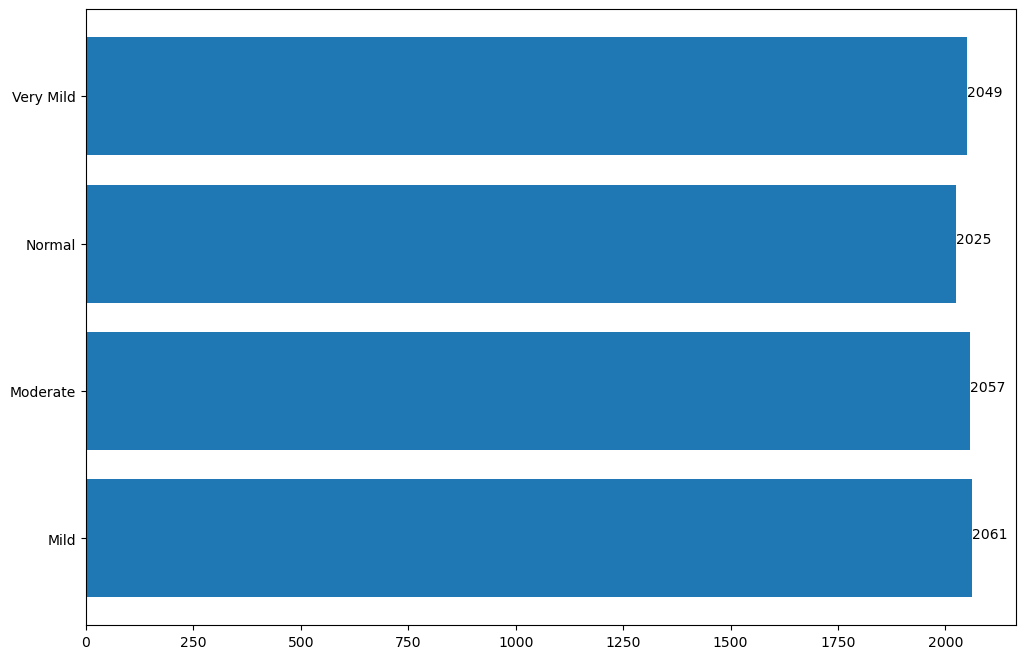

None


In [111]:
balanced_train_dist = class_distribution(train_data)
print(bar_chart(['Mild', 'Moderate', 'Normal', 'Very Mild'], balanced_train_dist))

# Custom CNN
Use the same model as the one before which was used for Dataset 1 (Imabalanced dataset)

In [115]:
tf.keras.backend.clear_session()

#This model was also finetuned just like before, on the balanced dataset, hence the few changes in hyperparameters.
#Custom CNN with updated hypeparameter values found from the tuner search
def create_model():
    
    #Clear any models defined to save RAM
    tf.keras.backend.clear_session()

    model = Sequential()

    model.add(Conv2D(480, (3, 3), activation='relu', padding='same', input_shape = (224, 224, 3)))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(320, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(288, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    
    model.add(Dense(352, activation='relu'))
    
    model.add(Dense(4, activation ='softmax'))
    
    return model

custom_model = create_model()
custom_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #Updated learning rate, lower rate means more epochs are needed for convergence (point of minimal loss) 
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

custom_model.build((None,224,224, 3))
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 480)     13440     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 480)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 320)     1382720   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 320)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 192)       553152    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 192)      0

## State of the art CNN architectures

Many well-known and pre-trained models were tested using their transfer learning capability to retrain them for Alzheimer's classifcation problem. Models from architecture families such as VGG, ResNet, DenseNet, Inception and EfficientNet had been finetuned for the Alzheimer's dataset. The best performing model was VGG19 (pre-trained on imagenet dataset) with it's convolutional layer's freezed to prevent modifying it's weights and biases.

### Fine-tuning hyperparameters using Keras Tuner.
Implementation adapted from the TensorFlow docs: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [51]:
#Fine-tune the hyperparameters of the top layers of the VGG19 model. This is important to increase performance of an already good model.
def finetune_VGG(hp):
    
    tf.keras.backend.clear_session()
    
    base_model = VGG19(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(224, 224, 3),
        include_top=False, # Do not include the ImageNet classifier at the top.
        pooling='avg' #Add a Global Average Pooling layer for reducing spatial dimension instead of flatten. Better performing than flatten in this case.
    )  
    
    #Freeze all layers of the VGG base itself
    for layer in base_model.layers:
        layer.trainable = False
    

    x = base_model.output
    
    #Try BatchNormalization to see if it improves performance
    if hp.Boolean("batch_norm"):
        x = layers.BatchNormalization()(x)
    
    #Similarly try dropout with variable dropout rates (rates should ideally be odd in common practice)
    if hp.Boolean('dropout'):
        dp_rate = hp.Choice("dropout_rate", values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
        x = layers.Dropout(dp_rate)(x)
    
    #Allow the tuner to choose no. of features between 32 and 512 with a step of 32 features.
    hp_units1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    x = layers.Dense(hp_units1, activation='relu')(x) #Let the tuner choose between relu and tanh activations
    predictions = layers.Dense(4, activation='softmax')(x) 
    
    #Instantiate a model object with input shape as the VGG19's specified shape of (224, 224, 3) and output as the predictions obtained from the softmax layer at the top.
    model = tf.keras.Model(base_model.input, predictions)
    
    #Opmtimize the learning rate too. This is a very important hyperparameter for model performance
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#Instantiate tuner for VGG model this time
finetune_VGG(kt.HyperParameters())

tuner = kt.Hyperband(finetune_VGG,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/kaggle/output/hp_tuning_vgg/',
                     project_name='cnn_kt')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#Hyperparameter search is commented as its time consuming (up to 2 hrs)
tuner.search(train_data, validation_data=val_data , epochs=20, callbacks=[early_stopping])


Trial 30 Complete [00h 01m 34s]
val_accuracy: 0.85498046875

Best val_accuracy So Far: 0.89453125
Total elapsed time: 00h 20m 40s


In [52]:
# Get the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal configuration of hyperparameters is: include BatchNorm: {best_hps.get('batch_norm')}, Dropout: {best_hps.get('dropout')}, Dropout Rate: {best_hps.get('dropout_rate')}. FC layer features should be {best_hps.get('units_1')}. The optimal learning rate for the optimizer is {best_hps.get('lr')}.
""")


The hyperparameter search is complete. The optimal configuration of hyperparameters is: include BatchNorm: True, Dropout: False, Dropout Rate: 0.5. FC layer features should be 160. The optimal learning rate for the optimizer is 0.005943090891599319.



In [27]:
# Get the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal configuration of hyperparameters is: include BatchNorm: {best_hps.get('batch_norm')}, Dropout: {best_hps.get('dropout')}, Dropout Rate: {best_hps.get('dropout_rate')}. FC layer features should be {best_hps.get('units_1')}. The optimal learning rate for the optimizer is {best_hps.get('lr')}.
""")


The hyperparameter search is complete. The optimal configuration of hyperparameters is: include BatchNorm: True, Dropout: False, Dropout Rate: 0.1. FC layer features should be 288. The optimal learning rate for the optimizer is 0.0048237811908727465.



In [112]:
#Finetuned VGG19 model
def create_vgg_model():
    
    tf.keras.backend.clear_session()
    
    #Use VGG19 base (only conv network, not the FC network)
    base_model = VGG19(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(224, 224, 3),
        include_top=False,
        pooling='avg'
    )  # Do not include the ImageNet classifier at the top.

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = tf.keras.layers.BatchNormalization()(x)
    #x = layers.Dropout(0.1)(x)
    #x = Flatten()(x)
    
    #x = Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    
    predictions = layers.Dense(4, activation='softmax')(x)
    
    model = tf.keras.Model(base_model.input, predictions)
    
    return model

vgg_model = create_vgg_model()

vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_model.summary()


80134624/80134624 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## Scratched CNN used in a research paper (will be referrred to as research model)
The following CNN model was found in a research paper (https://www.sciencedirect.com/science/article/pii/S0010482522003316#fig9) by Aurna et. al which performed very well on multi classification of brain tumours (similar domain to AD). The model hyperparameters were already fine-tuned by the researchers, I'm using their model to show a well performing model by the research community and compare their performance against the custom model used in this project.

In [28]:
#Finetuned model found in a research paper which was used for a similar classification problem with brain MR images as inputs 
# All hyperparameter values have been provided by the author's within the research article.
def create_research_model():
    
    tf.keras.backend.clear_session()
    
    model = Sequential()
    
    model.add(Conv2D(112, kernel_size=(5, 5), activation='relu', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(80, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(768))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(4, activation='softmax'))

    return model

research_model = create_research_model()

research_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

research_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 112)     8512      
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 220, 220, 112)     448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 112)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 80)      80720     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 108, 108, 80)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       2

# Training

### All 3 models (Custom CNN, VGG19 base, and Research) are trained on the same balanced dataset
After training, they are quickly evaluated on the test set and their learning loss and accuracy curves are plotted to see if they overfit/underfit/well-fit. Well-fit models generalise the best against unseen data.

In [8]:
#Custom Model training
custom_history = custom_model.fit(
    train_data,
    validation_data=val_data,
    callbacks=[tensorboard_callback], #Make sure to run the callback code block before running this .fit function
    epochs=30
)

Epoch 1/30
256/256 [==============================] - 51s 159ms/step - loss: 0.9540 - accuracy: 0.5499 - val_loss: 0.5378 - val_accuracy: 0.7686
Epoch 2/30
256/256 [==============================] - 23s 88ms/step - loss: 0.4475 - accuracy: 0.8062 - val_loss: 0.3505 - val_accuracy: 0.8545
Epoch 3/30
256/256 [==============================] - 23s 90ms/step - loss: 0.3033 - accuracy: 0.8724 - val_loss: 0.2786 - val_accuracy: 0.8818
Epoch 4/30
256/256 [==============================] - 23s 88ms/step - loss: 0.2024 - accuracy: 0.9181 - val_loss: 0.2299 - val_accuracy: 0.9019
Epoch 5/30
256/256 [==============================] - 23s 89ms/step - loss: 0.1364 - accuracy: 0.9459 - val_loss: 0.1699 - val_accuracy: 0.9263
Epoch 6/30
256/256 [==============================] - 24s 95ms/step - loss: 0.0902 - accuracy: 0.9678 - val_loss: 0.1881 - val_accuracy: 0.9248
Epoch 7/30
256/256 [==============================] - 23s 88ms/step - loss: 0.0769 - accuracy: 0.9729 - val_loss: 0.1207 - val_accuracy

In [9]:
# Evaluate the custom model on validation set
custom_model_metrics = custom_model.evaluate(val_data, verbose=2)
custom_model_metrics

64/64 - 2s - loss: 0.0598 - accuracy: 0.9858


[0.05982423201203346, 0.98583984375]

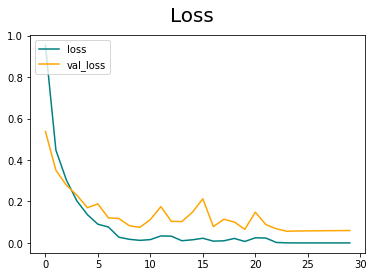

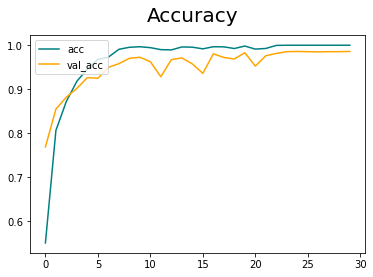

In [12]:
display_loss_and_accuracy_graphs(custom_history)

In [26]:
#VGG Model training
vgg_history = vgg_model.fit(
    train_data,
    validation_data=val_data,
    callbacks=[tensorboard_callback], #Make sure to run the callback code block before running this .fit function
    epochs=20
)

Epoch 1/5
256/256 [==============================] - 24s 93ms/step - loss: 0.0453 - accuracy: 0.9879 - val_loss: 0.2606 - val_accuracy: 0.9507
Epoch 2/5
256/256 [==============================] - 24s 92ms/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.3095 - val_accuracy: 0.9517
Epoch 3/5
256/256 [==============================] - 24s 92ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss: 0.2677 - val_accuracy: 0.9531
Epoch 4/5
256/256 [==============================] - 24s 94ms/step - loss: 0.0139 - accuracy: 0.9965 - val_loss: 0.3011 - val_accuracy: 0.9526
Epoch 5/5
256/256 [==============================] - 24s 92ms/step - loss: 0.0289 - accuracy: 0.9935 - val_loss: 0.3610 - val_accuracy: 0.9351


In [27]:
vgg_metrics = vgg_model.evaluate(val_data, verbose=2)
vgg_metrics

40/40 - 3s - loss: 0.5463 - accuracy: 0.9132


[0.5463398098945618, 0.9132134318351746]

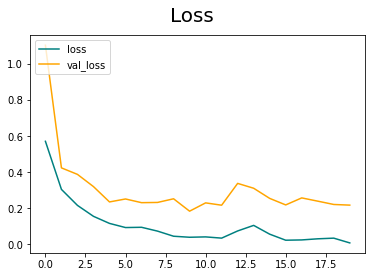

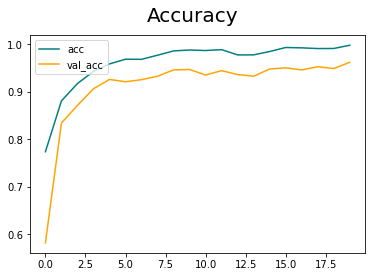

In [23]:
display_loss_and_accuracy_graphs(vgg_history)

In [29]:
research_history = research_model.fit(
    train_data,
    validation_data=val_data,
    callbacks=[tensorboard_callback, earlystopping], #Make sure to run the callback code block before running this .fit function
    epochs=20
)

Epoch 1/20
256/256 [==============================] - 23s 82ms/step - loss: 0.7995 - accuracy: 0.7479 - val_loss: 5.5308 - val_accuracy: 0.2930
Epoch 2/20
256/256 [==============================] - 20s 79ms/step - loss: 0.3801 - accuracy: 0.8585 - val_loss: 1.6941 - val_accuracy: 0.6792
Epoch 3/20
256/256 [==============================] - 20s 79ms/step - loss: 0.2260 - accuracy: 0.9203 - val_loss: 0.4612 - val_accuracy: 0.8516
Epoch 4/20
256/256 [==============================] - 20s 79ms/step - loss: 0.1462 - accuracy: 0.9425 - val_loss: 4.2160 - val_accuracy: 0.3755
Epoch 5/20
256/256 [==============================] - 20s 79ms/step - loss: 0.1090 - accuracy: 0.9602 - val_loss: 0.7365 - val_accuracy: 0.8213
Epoch 6/20
256/256 [==============================] - 20s 79ms/step - loss: 0.0771 - accuracy: 0.9729 - val_loss: 2.2016 - val_accuracy: 0.6382
Epoch 7/20
256/256 [==============================] - 20s 79ms/step - loss: 0.0559 - accuracy: 0.9785 - val_loss: 0.1826 - val_accuracy:

In [30]:
research_metrics = research_model.evaluate(val_data, verbose=2)
research_metrics

40/40 - 2s - loss: 0.2298 - accuracy: 0.9335


[0.22978858649730682, 0.9335418343544006]

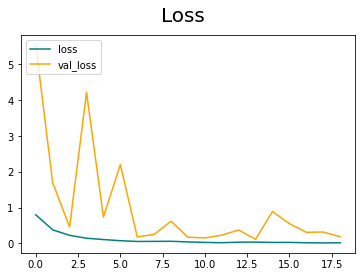

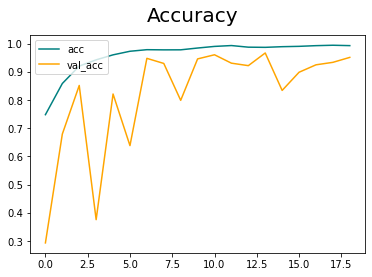

In [31]:
display_loss_and_accuracy_graphs(research_history)

### Cross-validation (optional: DONT RUN)
The dataset can be split in different ways. Using K-fold cross validation, if there are 5 k-folds then 4 of them can be the train set and the last 1 is validation set. The ordering of the folds can vary in 5 different positions/orders and this train split can be used to improve model performance by training the model on all possible images in the dataset.

In [ ]:
#Cross validation method to train models by K folds. Helps to generalise but it's time consuming so it's on hold.
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=False)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_images, train_labels.argmax(axis=1))):
    print(f'Fold {fold+1}')
    X_train, y_train = train_images[train_idx], train_labels[train_idx]
    X_val, y_val = train_images[val_idx], train_images[val_idx]
    
    # Define and train the model
    model = cnn_model
    model.fit(X_train, 
              y_train, 
              validation_data=(X_val, y_val),
              callbacks=[tensorboard_callback, earlystopping], #Make sure to run the callback code block before running this .fit function
              epochs=20
    )
    

    # Evaluate the model on the validation set
    y_pred = model.predict(test_images)
    acc = accuracy_score(test_labels.argmax(1), y_pred)
    #metrics = model.evaluate(test_data, verbose=2)
    print(acc)

Fold 1


# Performance Analysis
Display the performance metrics on the test set. Also view the classification report and confusion matrix to understand how the models perform in classifying each label

**IMPORTANT NOTE:** The function below must already have been ran before in the notebook (in the late stages of Dataset 1 approach)

In [15]:
#Custom model's test metrics
custom_test_labels, custom_pred_labels = get_labels_and_metrics(custom_model, test_data)

Accuracy:  0.9765442 
Loss:  0.10144035 
AUC:  0.9965585 
Precision:  0.97652584 
Recall:  0.9757623 
F1-score:  0.9761439532807636


In [32]:
#VGG model's test metrics
vgg_test_labels, vgg_pred_labels = get_labels_and_metrics(vgg_model, test_data)

Accuracy:  0.91321343 
Loss:  0.5056297 
AUC:  0.9703605 
Precision:  0.9137931 
Recall:  0.9116497 
F1-score:  0.9127201310474734


In [34]:
#Research model's test metrics
research_test_labels, research_pred_labels = get_labels_and_metrics(research_model, test_data)

Accuracy:  0.93354183 
Loss:  0.22915137 
AUC:  0.9902758 
Precision:  0.93422085 
Recall:  0.93275994 
F1-score:  0.9334898543358595


### Classification Report and Confusion Matrix

**IMPORATANT NOTE:** Make sure to run the following functions for all 3 models before displaying ANY ensemble learning performance metrics

              precision    recall  f1-score   support

        Mild       0.99      0.98      0.99       179
    Moderate       1.00      1.00      1.00        12
      Normal       0.97      0.99      0.98       640
   Very Mild       0.98      0.96      0.97       448

    accuracy                           0.98      1279
   macro avg       0.98      0.98      0.98      1279
weighted avg       0.98      0.98      0.98      1279



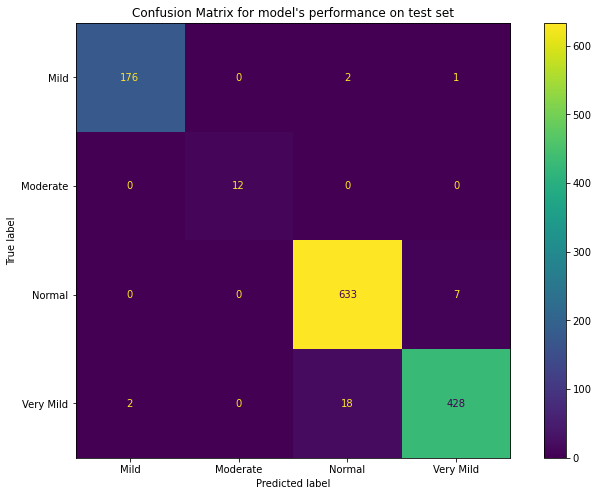

In [35]:
#Display classification report and confusion matrix of the custom model's performance
performance_metrics(custom_test_labels, custom_pred_labels, labels = ['Mild', 'Moderate', 'Normal', 'Very Mild'])

              precision    recall  f1-score   support

        Mild       0.84      0.93      0.89       179
    Moderate       1.00      0.83      0.91        12
      Normal       0.94      0.94      0.94       640
   Very Mild       0.91      0.87      0.89       448

    accuracy                           0.91      1279
   macro avg       0.92      0.89      0.91      1279
weighted avg       0.91      0.91      0.91      1279



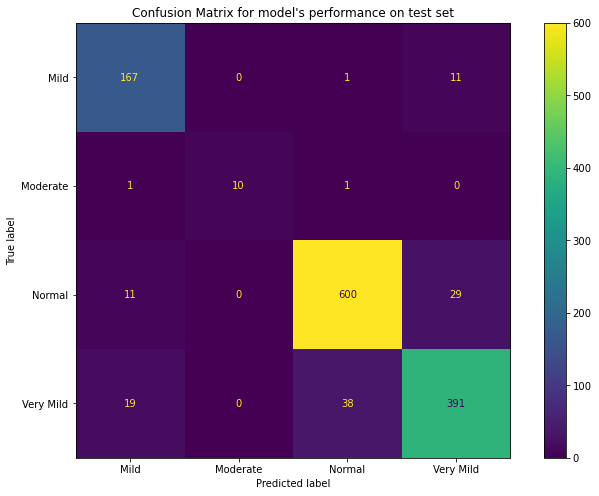

In [35]:
#Display classification report and confusion matrix of the VGG model's performance
performance_metrics(vgg_test_labels, vgg_pred_labels, labels = ['Mild', 'Moderate', 'Normal', 'Very Mild'])

              precision    recall  f1-score   support

        Mild       0.99      0.91      0.95       179
    Moderate       1.00      1.00      1.00        12
      Normal       0.95      0.93      0.94       640
   Very Mild       0.89      0.94      0.91       448

    accuracy                           0.93      1279
   macro avg       0.96      0.95      0.95      1279
weighted avg       0.94      0.93      0.93      1279



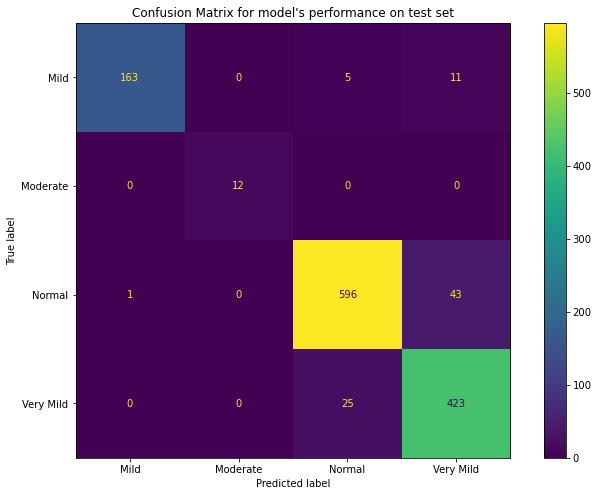

In [36]:
#Display classification report and confusion matrix of the research model's performance
performance_metrics(research_test_labels, research_pred_labels, labels = ['Mild', 'Moderate', 'Normal', 'Very Mild'])

## Saving Models (optional)
The custom CNN, research CNN and the best performing state-of-the-art model (VGG19) on this dataset are all saved before ensembling. This is an optional yet **recommended** step because when the notebook is loaded the next time, you don't need to define the models and train them again. They can just be loaded and their performances measured or be fed for ensembling steps.

In [40]:
#Saving the model for Future Inferences
#Models can be saved in many formats like json, h5 (either weights or arch), and SavedModel objects (folder files)
#We use SavedModel objects thus the below code is commented but nice to know if we want to change the format

"""
model_json = cnn_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn_model.save_weights("my_model.h5")
"""

In [109]:
# MODEL REUSE

# Save the weights (commented to prevent mistakes but you can uncommented and run)

#IF RUNNING ON LOCAL MACHINE RUN THIS
custom_model.save('/models/custom_model')

#IF RUNNING ON KAGGLE RUN THIS
#custom_model.save('/models/custom_model') #Don't save at custom_finetuned_model as its already used

In [21]:
#IF RUNNING ON LOCAL MACHINE RUN THIS
vgg_model.save('/models/vgg_model')

#IF RUNNING ON KAGGLE RUN THIS
#vgg_model.save('./models/vgg_model')

In [ ]:
#IF RUNNING ON LOCAL MACHINE RUN THIS
research_model.save('/models/research_model')

#IF RUNNING ON KAGGLE RUN THIS
#research_model.save('./models/research_model')

# Ensemble learning

There are a few ways to ensemble (amalgamate) models together. For example models can be concatenated by extracting features from 2 best models (in our case) and classifying input in the final model. These 3 models combine to form an ensembled model. Another way of ensembling is to sum the prediction probabilities of all 3 and thus improve the predictions as now it's based on a consensus of multiple models. We see both these methods applied below.

In [116]:
#Load all the saved models from the relevant directories containing SavedModel objects (only loads this file format)

#Only run the following commands for loading model if the model was saved successfully!!!

#research_model = tf.keras.models.load_model('./models/research_model')
#vgg_model = tf.keras.models.load_model('./models/vgg_model')
#custom_model = tf.keras.models.load_model('./models/custom_finetuned_model')

### Ensembling model outputs

In [5]:
tf.keras.backend.clear_session()

# First ensembling approach of concatenating multiple models and retraining them
custom_model = Model(inputs=custom_model.inputs, outputs=custom_model.outputs, name='Custom_Model')
research_model = Model(inputs=research_model.inputs, outputs=research_model.outputs, name='Research_Model')
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.outputs, name='VGG_Model')

models = [vgg_model, research_model, custom_model]
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='Ensemble_Model')

In [6]:
ensemble_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
ensemble_model.summary()

Model: "Ensemble_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Model (Functional)          (None, 4)            20291140    input_1[0][0]                    
__________________________________________________________________________________________________
Research_Model (Functional)     (None, 4)            4604980     input_1[0][0]                    
__________________________________________________________________________________________________
Custom_Model (Functional)       (None, 4)            9541352     input_1[0][0]                    
_____________________________________________________________________________________

In [7]:
ensemble_history = ensemble_model.fit(
    train_data,
    validation_data=val_data,
    #callbacks=[tensorboard_callback, earlystopping], #Make sure to run the callback code block before running this .fit function
    epochs=5
)

Epoch 1/5
256/256 [==============================] - 135s 460ms/step - loss: 0.0109 - accuracy: 0.9999 - val_loss: 0.0482 - val_accuracy: 0.9897
Epoch 2/5
256/256 [==============================] - 118s 460ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9893
Epoch 3/5
256/256 [==============================] - 118s 459ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0381 - val_accuracy: 0.9888
Epoch 4/5
256/256 [==============================] - 118s 460ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9897
Epoch 5/5
256/256 [==============================] - 118s 459ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0413 - val_accuracy: 0.9912


In [8]:
# Evaluate the model on the validation set
metrics = ensemble_model.evaluate(val_data, verbose=2)
metrics

64/64 - 11s - loss: 0.0413 - accuracy: 0.9912


[0.04127545282244682, 0.9912109375]

In [10]:
test_metrics = ensemble_model.evaluate(test_data, verbose=2)
test_metrics

40/40 - 13s - loss: 0.0803 - accuracy: 0.9812


[0.0802614763379097, 0.9812353253364563]

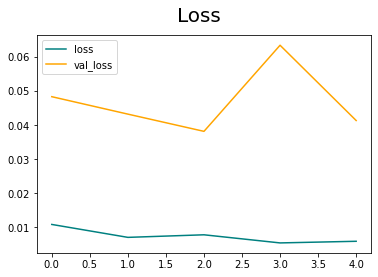

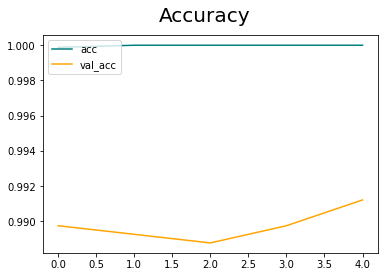

In [17]:
#Display loss and accuracy graphs of the ensemble model's training session
display_loss_and_accuracy_graphs(ensemble_history)

In [19]:
ensemble_test_labels, ensemble_pred_labels = get_labels_and_metrics(ensemble_model, test_data)

Accuracy:  0.9812353 
Loss:  0.08026148 
AUC:  0.99897873 
Precision:  0.984252 
Recall:  0.97732604 
F1-score:  0.9807768004064926


              precision    recall  f1-score   support

        Mild       0.99      0.98      0.99       179
    Moderate       1.00      1.00      1.00        12
      Normal       0.97      1.00      0.98       640
   Very Mild       0.99      0.96      0.97       448

    accuracy                           0.98      1279
   macro avg       0.99      0.98      0.99      1279
weighted avg       0.98      0.98      0.98      1279



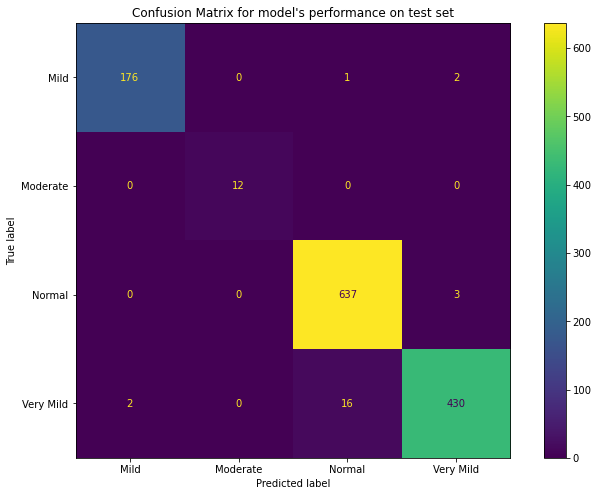

In [20]:
performance_metrics(ensemble_test_labels, ensemble_pred_labels, labels = ['Mild', 'Moderate', 'Normal', 'Very Mild'])

### Ensembling predicitons

In [21]:
#Second ensembling approach of averaging just the predictions of all 3 models
best_models = [vgg_model, research_model, custom_model]

true_labels = []
pred_labels = []

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
auc = AUC()
loss = CategoricalCrossentropy()

for batch in test_data.as_numpy_iterator():
    X, y = batch
    preds = [model.predict(X) for model in best_models]
    avg_pred = np.sum(preds, axis=0)/3
    
    pre.update_state(y, avg_pred)
    re.update_state(y, avg_pred)
    acc.update_state(y, avg_pred)
    auc.update_state(y, avg_pred)
    loss.update_state(y, avg_pred)
    
    true_labels.append(y)
    pred_labels.append(avg_pred)

#IMPORTANT: Make sure to run the conv_list_to_array function found in the Model Evaluation and Performance Analysis section above.
true_labels = conv_list_to_array(true_labels) 
pred_labels = conv_list_to_array(pred_labels)

In [22]:
f1_score = 2 * (pre.result().numpy() * re.result().numpy()) / (pre.result().numpy() + re.result().numpy())


print("Accuracy: ", acc.result().numpy(),"Loss: ",loss.result().numpy(), "AUC: ",auc.result().numpy(), "Precision: ",pre.result().numpy()," Recall: ", re.result().numpy(), "F1-score: ",f1_score)

Accuracy:  0.9812353 Loss:  0.080261484 AUC:  0.99897873 Precision:  0.984252  Recall:  0.97732604 F1-score:  0.9807768004064926


              precision    recall  f1-score   support

        Mild       0.98      0.99      0.99       179
    Moderate       1.00      1.00      1.00        12
      Normal       0.98      0.99      0.99       640
   Very Mild       0.98      0.96      0.97       448

    accuracy                           0.98      1279
   macro avg       0.99      0.99      0.99      1279
weighted avg       0.98      0.98      0.98      1279



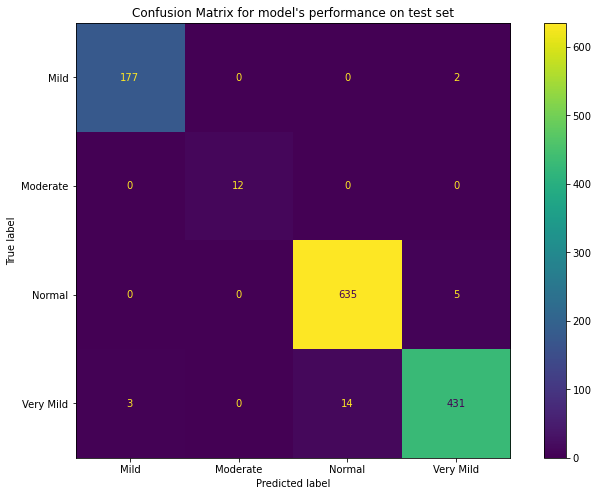

In [42]:
performance_metrics(true_labels, pred_labels, labels = ['Mild', 'Moderate', 'Normal', 'Very Mild'])

# Predict single or multiple images

## Single image prediction

* If we want to confirm a model works well then a single image can be loaded
* Image must be preprocessed and then it can be displayed
* The image is passed to a model.predict() function to get a probability distribution of the predictions

Prediction: Moderate Impairment


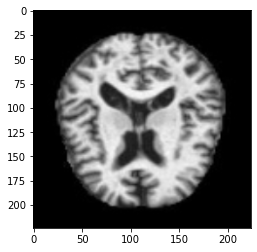

In [39]:
#from PIL import Image

image_path = '/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/Moderate Impairment/19.jpg'
image = tf.keras.utils.load_img(image_path)
image = tf.image.resize(image, (224,224))
input_arr = tf.keras.utils.img_to_array(image)
input_arr = input_arr/255
imgplot = plt.imshow(input_arr)
input_arr = input_arr.reshape((1,) + input_arr.shape) #np.array([input_arr])  # Convert single image to a batch.

#Choose model to predict the image
predictions = ensemble_model.predict(input_arr)
label_index = np.argmax(predictions, axis=1)

if label_index == 0:
    print('Prediction: Mild Impairment')
elif label_index == 1:
    print('Prediction: Moderate Impairment')
elif label_index == 2:
    print('Prediction: No Impairment')
elif label_index == 3:
    print('Prediction: Very Mild Impairment')
else:
    print("Error: Index Overflow")

## Multi-image prediction


* An entire directory with the same labels is loaded (helps us to know the true labels).
* All images are preprocessed and converted to numpy arrays which the model expects.
* Model predicts all images and the predicted label counts is calculated for visualising.

In [121]:
pwd

'/Users/main/Desktop/lab2/FinalYrProject'

In [30]:
#IF RUNNING ON LOCAL MACHINE
dirs = ['./AlzheimersDataset/test/ModerateDemented', './AlzheimersDataset/test/NonDemented'] #'/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/Very Mild Impairment'

#IF RUNNING ON KAGGLE:
#dirs = ['/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/Moderate Impairment', '/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/No Impairment'] #'/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/Very Mild Impairment'

image_list = []
for dir in dirs:
    for filename in os.listdir(dir):

        # Load the image from file
        img = tf.keras.utils.load_img(os.path.join(dir, filename))
        x = tf.image.resize(img, (224,224))
        # Convert the image to an array
        x = tf.keras.utils.img_to_array(x)
        x = x/255
        image_list.append(x)

        # Reshape the array to have a batch size of 1
        #x = x.reshape((1,) + x.shape)

mybatch = np.array(image_list)


In [31]:
#Choose a model to predict the images
preds = ensemble_model.predict(mybatch)

i0 = 0
i1 = 0
i2 = 0
i3 = 0

for i in range(len(preds)):
        #print("Predicted class: ", preds[i], preds[i].argmax(axis=-1))
        if preds[i].argmax(axis=-1) == 0:
            i0 += 1
        elif preds[i].argmax(axis=-1) == 1:
            i1 += 1
        elif preds[i].argmax(axis=-1) == 2:
            i2 += 1
        elif preds[i].argmax(axis=-1) == 3:
            i3 += 1
        else:
            print("Invalid class prediction")

print("Mild: {}, Moderate: {}, CN: {}, Very Mild: {}".format(i0, i1, i2, i3))

Mild: 0, Moderate: 12, CN: 638, Very Mild: 2


# Grad-CAM visualization
To know what areas of an image the model focuses on, we can use Grad-CAM heatmaps to overlay the output of the final convolutional layer on top of the input image. This will mark areas of interest using hot colors such as red, orange or yellow.

In [112]:
# See the model architecture to find the final convolutional layer
custom_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 480)     13440     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 480)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 320)     1382720   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 320)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 192)       553152    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 192)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 512)       8

### The following 3 cells of code have been used from Keras documentation (https://keras.io/examples/vision/grad_cam/) whilst adapting them to this project

In [135]:
def get_img_array(img_path, size):
    image = tf.keras.utils.load_img(img_path)
    image = tf.image.resize(image, size)
    input_arr = tf.keras.utils.img_to_array(image)
    input_arr = input_arr/255
    input_arr = input_arr.reshape((1,) + input_arr.shape) #np.array([input_arr])  # Convert single image to a batch.
    print(input_arr.shape)
    return input_arr


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



(1, 224, 224, 3)
Predicted: [[1.14979734e-07 9.99999881e-01 4.43536614e-12 9.72226744e-09]]


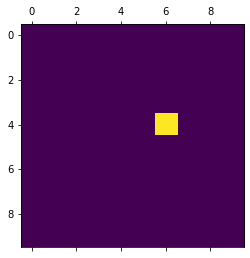

In [215]:
img_path = './Combined Dataset/test/Moderate Impairment/9 (2).jpg'
last_conv_layer = 'conv2d_4'

# Prepare image
img_array = get_img_array(img_path, size=(224,224))

# Remove last layer's softmax
custom_model.layers[-1].activation = None

# Print what the top predicted class is
preds = custom_model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, custom_model, last_conv_layer)

# Display heatmap
plt.matshow(heatmap)
plt.show()

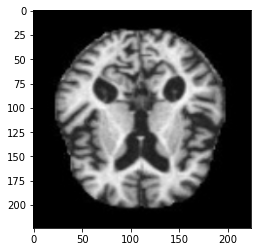

In [216]:
imgplot = plt.imshow(img_array[0])

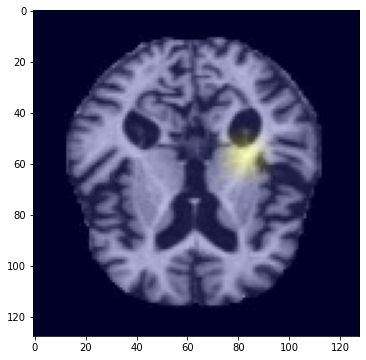

In [217]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("plasma")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    plt.figure(figsize=(6,6))
    plt.imshow(superimposed_img)


save_and_display_gradcam(img_path, heatmap)

# File Manipulation (optional)

## IMPORTANT NOTE: Don't run the following cells
Helper functions mainly for dealing with augmented images. Add augmented images to the dataset or remove extra images from large unbalanced classes.

In [14]:
directory = "./AugmentedTrain/VeryMildDemented"

files = [os.path.join(directory, filename) for filename in os.listdir(directory)]
len(files)

4801

In [18]:
for i in range(792):
  if i == 0:
    fname = "ssdsk"
  elif i < 10:
    fname = "verymildDem100"+str(i)+".jpg"
  elif i >= 10 and i < 100:
    fname = "verymildDem10"+str(i)+".jpg"
  else:
    fname = "verymildDem1"+str(i)+".jpg"
  #print(fname)
  

  if os.path.exists(fname):
      os.remove(fname)
  else:
      print("The file does not exist")

  

The file does not exist


In [41]:
filesToRemove = []
i = 0
for file in files:
    if "moderateDem102" in file or "moderateDem103" in file:
        i += 1
        print(file)
        filesToRemove.append(file)
        
i

moderateDem102_0_8562.jpg
moderateDem102_0_628.jpg
moderateDem103_0_5628.jpg
moderateDem103_0_5454.jpg
moderateDem102_0_4505.jpg
moderateDem103_0_1230.jpg
moderateDem103_0_9945.jpg
moderateDem102_0_8270.jpg
moderateDem103_0_2228.jpg
moderateDem103_0_4966.jpg
moderateDem103_0_6854.jpg
moderateDem102_0_7695.jpg
moderateDem102_0_7040.jpg
moderateDem102_0_9389.jpg
moderateDem102_0_9005.jpg
moderateDem102_0_3586.jpg
moderateDem102_0_77.jpg
moderateDem102_0_5267.jpg
moderateDem103_0_2683.jpg
moderateDem102_0_9383.jpg
moderateDem102_0_9404.jpg
moderateDem103_0_2481.jpg
moderateDem103_0_6329.jpg
moderateDem102_0_6109.jpg
moderateDem103_0_5148.jpg
moderateDem103_0_6646.jpg
moderateDem102_0_8126.jpg
moderateDem103_0_655.jpg
moderateDem102_0_2394.jpg
moderateDem102_0_5783.jpg
moderateDem103_0_899.jpg
moderateDem102_0_4660.jpg
moderateDem102_0_5001.jpg
moderateDem103_0_5024.jpg
moderateDem103_0_3922.jpg
moderateDem103_0_1814.jpg
moderateDem103_0_1233.jpg
moderateDem103_0_8651.jpg


38

In [42]:
for currentFile in filesToRemove:
    if os.path.exists(currentFile):
      #os.remove(currentFile)
    else:
      print("The file does not exist")